In [1]:
import pandas as pd
import numpy as np

In [2]:
train_df = pd.read_csv('datasets/titanic/train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_df = train_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked', 'SibSp', 'Parch'])
train_df = pd.get_dummies(train_df, columns=['Sex']).drop(columns='Sex_female')
train_df = train_df.fillna({'Age': train_df['Age'].median()})
train_df.head()

,Survived,Pclass,Age,Fare,Sex_male
0,0,3,22.0,7.2500,1
1,1,1,38.0,71.2833,0
2,1,3,26.0,7.9250,0
3,1,1,35.0,53.1000,0
4,0,3,35.0,8.0500,1


In [4]:
from kurilib.data import normalize_columns
normalize_columns(train_df, columns=['Age', 'Fare'])
train_df.head()

,Survived,Pclass,Age,Fare,Sex_male
0,0,3,0.271174,0.014151,1
1,1,1,0.472229,0.139136,0
2,1,3,0.321438,0.015469,0
3,1,1,0.434531,0.103644,0
4,0,3,0.434531,0.015713,1


In [5]:
X = train_df.drop(columns='Survived')
y = train_df['Survived']

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Самописный градиентный спуск + логистическая регрессия

In [8]:
from kurilib.linear import StandardGradientDescent
from kurilib.quality_functional import LogisticLoss
from kurilib.quality_functional import Accuracy

accs = []

for S in range(100, 1000, 100):
    gd = StandardGradientDescent(S=S, loss='logistic', descent_method='normalization const', step=0.01)
    gd.fit(X_train, y_train)
    y_pred = gd.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)
    accs.append(Accuracy.get_accuracy(y_pred, y_test))

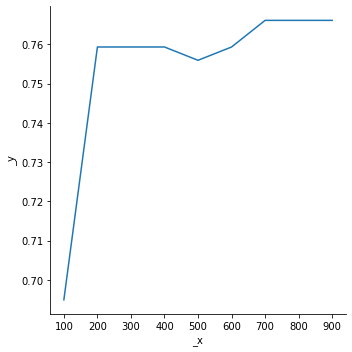

In [9]:
import seaborn as sns
sns.relplot(x=list(range(100, 1000, 100)), y=accs, kind='line')

In [11]:
gd = StandardGradientDescent(step=0.005, S=600, loss='logistic', descent_method='normalization const')
gd.fit(X_train, y_train)
y_pred = gd.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
Accuracy.get_accuracy(y_pred, y_test)

0.7593220338983051

In [12]:
test_df = pd.read_csv('datasets/titanic/test.csv')
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [13]:
test_df.isna().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked       False
dtype: bool

In [14]:
predicts_df = pd.DataFrame(test_df['PassengerId'])

In [15]:
test_df = test_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked', 'SibSp', 'Parch'])
test_df = pd.get_dummies(test_df, columns=['Sex']).drop(columns='Sex_female')
test_df = test_df.fillna({'Age': test_df['Age'].median(), 'Fare': test_df['Age'].mean()})
normalize_columns(test_df, columns=['Age', 'Fare'])
test_df.head()

,Pclass,Age,Fare,Sex_male
0,3,0.452723,0.015282,1
1,3,0.617566,0.013663,0
2,2,0.815377,0.018909,1
3,3,0.353818,0.016908,1
4,3,0.287881,0.023984,0


In [16]:
predicts_df['Survived'] = (gd.predict(test_df) > 0.5).astype(int)

In [17]:
predicts_df.to_csv('predicts.csv', index=False)

### Результат ~0.73, но включив фичу Fare результат возрос до 0.767

# Логистическая регрессия sklearn

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
lr = LogisticRegression(penalty='none')

In [20]:
lr.fit(X_train, y_train)

LogisticRegression(penalty='none')

In [21]:
Accuracy.get_accuracy(lr.predict(X_test), y_test)

0.7694915254237288

In [22]:
predicts_df['Survived'] = lr.predict(test_df)

In [23]:
predicts_df.to_csv('predicts.csv', index=False)

### Результат без регуляризации ~0.74

Попробую улучшить результат, варьируя различные параметры этой модели

In [24]:
lr = LogisticRegression(penalty='l1', solver='liblinear')

In [25]:
lr.fit(X_train, y_train)
Accuracy.get_accuracy(lr.predict(X_test), y_test)

0.7661016949152543

In [26]:
predicts_df['Survived'] = lr.predict(test_df)
predicts_df.to_csv('predicts.csv', index=False)

### L1-регуляризация здесь показала лучший результат, чем L2 (~0.76 против ~0.75)

# Исследуем датасет поглубже

In [27]:
titanic_df = pd.read_csv('datasets/titanic/train.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [28]:
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [29]:
titanic_df = titanic_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Embarked', 'SibSp', 'Parch'])
titanic_df.head()

,Survived,Pclass,Sex,Age,Fare,Cabin
0,0,3,male,22.0,7.2500,NaN
1,1,1,female,38.0,71.2833,C85
2,1,3,female,26.0,7.9250,NaN
3,1,1,female,35.0,53.1000,C123
4,0,3,male,35.0,8.0500,NaN


Стобец PassengerId точно не несет в себе полезной информации, также как столбцы Ticket и Name.
Столбцы Pclass, Sex, Age и Fare мы уже использовали.
Происследуем столбец Cabin - было бы логично, что пассажиры, проживающие в нижних каютах имели меньший шанс на выживание.

In [30]:
titanic_df.isna().any()

Survived    False
Pclass      False
Sex         False
Age          True
Fare        False
Cabin        True
dtype: bool

Необходимо что-то сделать с пропусками в столбцах Age и Cabin. Как вариант - пропуски в Age заполнять медианными значениями, а объекты с пропусками в Cabin удалять.

In [31]:
titanic_df = titanic_df.fillna({'Age': titanic_df['Age'].median()})
titanic_df['Cabin'].isna().sum()

687

У большей части пассажиров неизвестны номера их кают - значит удалять их точно не вариант.

In [32]:
titanic_df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

Можно заметить, что у некоторых пассажиров встречаются сразу несколько номеров кают.
Согласно информации с сайта https://aif.ru/dontknows/infographics/paluby_i_kayuty_titanika_infografika, палуба A находилась в самом верху судна, а палуба G - в самом низу. Вряд ли из численной части номера можно вытащить полезную информацию, в отличии от буквы.

Палуб (и соответственно букв) конечное число, поэтому можно породить категариальный признак Deck, который затем двоично закодировать n-1 признаками. 
Также вознимкает идея считать пропуск отдельной категорией.

In [33]:
get_deck_from_cabin = lambda s: s[0] if type(s) == str else np.nan

In [34]:
titanic_df['Deck'] = titanic_df['Cabin'].apply(get_deck_from_cabin)
titanic_df['Deck'].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [35]:
titanic_df = pd.get_dummies(titanic_df, columns=['Deck', 'Sex']).drop(columns=['Cabin', 'Sex_female', 'Deck_T'])
titanic_df.head()

,Survived,Pclass,Age,Fare,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Sex_male
0,0,3,22.0,7.2500,0,0,0,0,0,0,0,1
1,1,1,38.0,71.2833,0,0,1,0,0,0,0,0
2,1,3,26.0,7.9250,0,0,0,0,0,0,0,0
3,1,1,35.0,53.1000,0,0,1,0,0,0,0,0
4,0,3,35.0,8.0500,0,0,0,0,0,0,0,1


Нормализуем фичи Age и Fare

In [36]:
from kurilib.data import normalize_columns
normalize_columns(titanic_df, columns=['Age', 'Fare'])
titanic_df.head()

,Survived,Pclass,Age,Fare,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Sex_male
0,0,3,0.271174,0.014151,0,0,0,0,0,0,0,1
1,1,1,0.472229,0.139136,0,0,1,0,0,0,0,0
2,1,3,0.321438,0.015469,0,0,0,0,0,0,0,0
3,1,1,0.434531,0.103644,0,0,1,0,0,0,0,0
4,0,3,0.434531,0.015713,0,0,0,0,0,0,0,1


In [37]:
X_train = titanic_df.drop(columns='Survived')
y_train = titanic_df['Survived']

In [38]:
gd = StandardGradientDescent(step=0.005, S=500, loss='logistic', descent_method='normalization const')
gd.fit(X_train, y_train)

In [39]:
test_df = pd.read_csv('datasets/titanic/test.csv')
test_df = test_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Embarked', 'SibSp', 'Parch'])
test_df = test_df.fillna({'Age': test_df['Age'].median(), 'Fare': test_df['Fare'].mean()})
get_deck_from_cabin = lambda s: s[0] if type(s) == str else np.nan
test_df['Deck'] = test_df['Cabin'].apply(get_deck_from_cabin)
test_df = pd.get_dummies(test_df, columns=['Deck', 'Sex']).drop(columns=['Cabin', 'Sex_female'])
normalize_columns(test_df, columns=['Age', 'Fare'])
test_df

,Pclass,Age,Fare,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Sex_male
0,3,0.452723,0.015282,0,0,0,0,0,0,0,1
1,3,0.617566,0.013663,0,0,0,0,0,0,0,0
2,2,0.815377,0.018909,0,0,0,0,0,0,0,1
3,3,0.353818,0.016908,0,0,0,0,0,0,0,1
4,3,0.287881,0.023984,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
413,3,0.353818,0.015713,0,0,0,0,0,0,0,1
414,1,0.512066,0.212559,0,0,1,0,0,0,0,0
415,3,0.505473,0.014151,0,0,0,0,0,0,0,1
416,3,0.353818,0.015713,0,0,0,0,0,0,0,1


In [40]:
predicts_df['Survived'] = (gd.predict(test_df) > 0.5).astype(int)
predicts_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [41]:
predicts_df.to_csv('predicts.csv', index=False)

## Результат дотянул до моего рекордного 0.77272, но не улучшился :(

Исследуем числовые признаки

<AxesSubplot:xlabel='Age'>

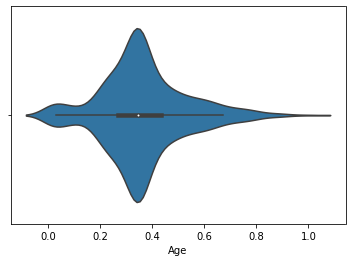

In [42]:
sns.violinplot(x=titanic_df['Age'])

<AxesSubplot:xlabel='Fare'>

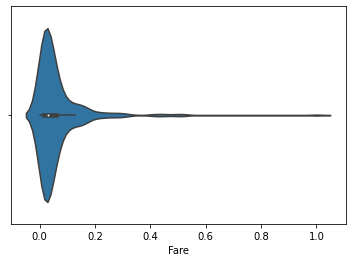

In [43]:
sns.violinplot(x=titanic_df['Fare'])

Можно удалить данные, в которых Fare превышает, например, 0.3

In [44]:
titanic_df = titanic_df.query('Fare < 0.3')

In [45]:
X_train = titanic_df.drop(columns='Survived')
y_train = titanic_df['Survived']

In [46]:
gd = StandardGradientDescent(step=0.005, S=200, loss='logistic')
gd.fit(X_train, y_train)

In [47]:
predicts_df['Survived'] = (gd.predict(test_df) > 0.5).astype(int)
predicts_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [48]:
predicts_df.to_csv('predicts.csv', index=False)

## Результат нисколько не улучшился

Попробуем логистическую регрессию из sklearn

In [49]:
lr = LogisticRegression(penalty='l2')

In [50]:
lr.fit(X_train, y_train)

LogisticRegression()

In [51]:
predicts_df['Survived'] = lr.predict(test_df)
predicts_df.to_csv('predicts.csv', index=False)

## Результат ухудшился до ~0.75

Попробуем теперь учитывать признаки SibSp и ParCh, и не учитывать Cabin

In [52]:
titanic_df = pd.read_csv('datasets/titanic/train.csv')
titanic_df = titanic_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Embarked', 'Cabin'])
titanic_df = titanic_df.fillna({'Age': titanic_df['Age'].median()})
titanic_df = pd.get_dummies(titanic_df, columns=['Sex']).drop(columns='Sex_female')
normalize_columns(titanic_df, columns=['Age', 'Fare'])
X = titanic_df.drop(columns='Survived')
y = titanic_df['Survived']
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.25)

In [54]:
gd = StandardGradientDescent(step=0.005, S=200, loss='logistic')
gd.fit(X_train, y_train)

In [55]:
test_df = pd.read_csv('datasets/titanic/test.csv')
test_df = test_df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Embarked', 'Cabin'])
test_df = test_df.fillna({'Age': test_df['Age'].median(), 'Fare': test_df['Fare'].mean()})
test_df = pd.get_dummies(test_df, columns=['Sex']).drop(columns=['Sex_female'])
normalize_columns(test_df, columns=['Age', 'Fare'])

In [56]:
predicts_df['Survived'] = (gd.predict(test_df) > 0.5).astype(int)
predicts_df.to_csv('predicts.csv', index=False)

## Результат не улучшился

Попробуем из признаков SibSp и Parch породить новый признак Family

In [57]:
titanic_df['Family'] = titanic_df['SibSp'] + titanic_df['Parch']
titanic_df = titanic_df.drop(columns=['SibSp', 'Parch'])
X = titanic_df.drop(columns='Survived')
y = titanic_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [59]:
gd = StandardGradientDescent(step=0.005, S=200, loss='logistic')
gd.fit(X_train, y_train)

In [60]:
test_df['Family'] = test_df['SibSp'] + test_df['Parch']
test_df = test_df.drop(columns=['SibSp', 'Parch'])

In [61]:
predicts_df['Survived'] = (gd.predict(test_df) > 0.5).astype(int)
predicts_df.to_csv('predicts.csv', index=False)

## Результат улучшился совсем немного - до 0.77751

# kNN

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

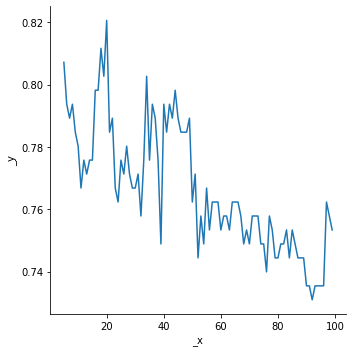

In [63]:
from kurilib.metric_methods import kNearestNeighbors
accs = []
for k in range(5, 100):
    knn = kNearestNeighbors(k=k, X=X_train, y=y_train, choice_method='popular')
    accs.append(Accuracy.get_accuracy(y_test, knn.predict(X_test)))
    
sns.relplot(x=range(5, 100), y=accs, kind='line')

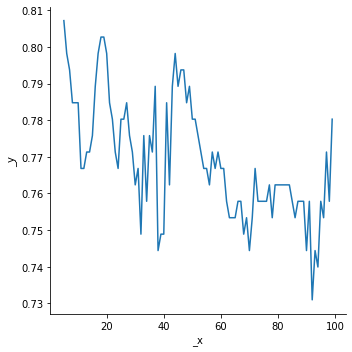

In [64]:
accs = []
for k in range(5, 100):
    knn = kNearestNeighbors(k=k, X=X_train, y=y_train, choice_method='weighted')
    accs.append(Accuracy.get_accuracy(y_test, knn.predict(X_test)))
    
sns.relplot(x=range(5, 100), y=accs, kind='line')

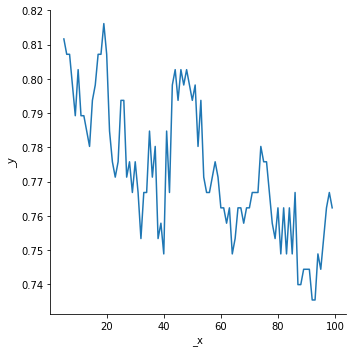

In [65]:
accs = []
for k in range(5, 100):
    knn = kNearestNeighbors(k=k, X=X_train, y=y_train, choice_method='weighted', metric='manhattan')
    accs.append(Accuracy.get_accuracy(y_test, knn.predict(X_test)))
    
sns.relplot(x=range(5, 100), y=accs, kind='line')

Вывод: используем ~30 соседей, взвешенный вариант. Метрика любая


In [66]:
knn = kNearestNeighbors(k=60, X=X, y=y, choice_method='weighted', metric='manhattan')
predicts_df['Survived'] = (knn.predict(test_df)).astype(int)
predicts_df.to_csv('predicts.csv', index=False)

In [67]:
predicts_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


# CatBoost

In [38]:
import pandas as pd
import numpy as np
import catboost as cb

In [39]:
train_df = pd.read_csv('datasets/titanic/train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [40]:
X = train_df[['Pclass', 'Sex', 'Age', 'Fare']]
y = train_df['Survived']

In [41]:
X.head()

,Pclass,Sex,Age,Fare
0,3,male,22.0,7.2500
1,1,female,38.0,71.2833
2,3,female,26.0,7.9250
3,1,female,35.0,53.1000
4,3,male,35.0,8.0500


Pclass и Sex закодируем one-hot:

In [42]:
X = pd.get_dummies(data=X, columns=['Pclass', 'Sex']).drop(columns=['Pclass_3', 'Sex_female'])
X.head()

,Age,Fare,Pclass_1,Pclass_2,Sex_male
0,22.0,7.2500,0,0,1
1,38.0,71.2833,1,0,0
2,26.0,7.9250,0,0,0
3,35.0,53.1000,1,0,0
4,35.0,8.0500,0,0,1


In [45]:
from kurilib.data import normalize_columns
normalize_columns(df=X, columns=['Age', 'Fare'])
X['Family'] = train_df['SibSp'] + train_df['Parch']
X.head()

,Age,Fare,Pclass_1,Pclass_2,Sex_male,Family
0,0.271174,0.014151,0,0,1,1
1,0.472229,0.139136,1,0,0,1
2,0.321438,0.015469,0,0,0,0
3,0.434531,0.103644,1,0,0,1
4,0.434531,0.015713,0,0,1,0


In [60]:
params = {
    'loss_function': 'Logloss',
    'iterations': 150,
    'learning_rate': 0.05,
    'custom_loss': 'AUC',
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.5,
    'rsm': 1.0,
    'l2_leaf_reg': 3,
    'leaf_estimation_method': 'Newton'
}

cat_features = [2, 3, 4]

cv_data = cb.cv(
    pool=cb.Pool(X, label=y, cat_features=cat_features),
    params=params,
    fold_count=5,
    type='Classical',
    shuffle=True,
    plot=True,
    stratified=True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [61]:
best_clfr = cb.CatBoostClassifier(
    iterations=100,
    learning_rate=0.5,
    bootstrap_type= 'Bernoulli',
    subsample=0.5,
    rsm=1.0,
    leaf_estimation_method='Newton'
)
best_clfr.fit(X, y, cat_features=cat_features, verbose=10)

0:	learn: 0.5410837	total: 672us	remaining: 66.6ms
10:	learn: 0.3860253	total: 9.2ms	remaining: 74.4ms
20:	learn: 0.3514485	total: 15.2ms	remaining: 57.3ms
30:	learn: 0.3225697	total: 21.5ms	remaining: 47.8ms
40:	learn: 0.3065904	total: 27.8ms	remaining: 39.9ms
50:	learn: 0.2890952	total: 34ms	remaining: 32.6ms
60:	learn: 0.2724950	total: 40.1ms	remaining: 25.6ms
70:	learn: 0.2610119	total: 46.4ms	remaining: 18.9ms
80:	learn: 0.2504947	total: 52.5ms	remaining: 12.3ms
90:	learn: 0.2374201	total: 58.8ms	remaining: 5.81ms
99:	learn: 0.2271091	total: 64.5ms	remaining: 0us


In [70]:
X_test = pd.read_csv('datasets/titanic/test.csv')[['Pclass', 'Sex', 'Age', 'Fare', 'SibSp', 'Parch']]
X_test = pd.get_dummies(X_test, columns=['Pclass', 'Sex']).drop(columns=['Pclass_3', 'Sex_female'])
X_test['Family'] = X_test['SibSp'] + X_test['Parch']
X_test = X_test.drop(columns=['SibSp', 'Parch'])
normalize_columns(X_test, ['Age', 'Fare'])
X_test.head()

,Age,Fare,Pclass_1,Pclass_2,Sex_male,Family
0,0.452723,0.015282,0,0,1,0
1,0.617566,0.013663,0,0,0,1
2,0.815377,0.018909,0,1,1,0
3,0.353818,0.016908,0,0,1,0
4,0.287881,0.023984,0,0,0,2


In [76]:
test_pool = cb.Pool(data=X_test, cat_features = cat_features)
preds = best_clfr.predict(test_pool)
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,

In [85]:
preds_df = pd.read_csv('datasets/titanic/test.csv')[['PassengerId']]
preds_df['Survived'] = preds
preds_df.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


In [86]:
preds_df.to_csv('predicts.csv', index=False)